In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time
import seaborn as sns
import math 
import os
import errno
import matplotlib.patches as patches
import operator
import pdb
import warnings
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse, Circle
from datetime import timedelta
from datetime import datetime
from dateutil.relativedelta import relativedelta
from geopy.geocoders import Nominatim

warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

In [3]:
#reusing old folder to fetch users and their corresponding month year with highest data

usern_mnth_df = pd.DataFrame()
usern_mnth_df['user'] = ""
usern_mnth_df['year'] = ""
usern_mnth_df['month'] = ""

file_list = glob.glob("C:/Users/12sha/Documents/thesislocation/Data/User stay points(month-maxdata, 50m 30min)/*.png")
for i in range(0, len(file_list)):
    file_name = file_list[i]
    user = file_name[88:91]
    year = file_name[102:106]
    month = file_name[106:108]
    month = int(month)
    usern_mnth_df.loc[i, 'user'] = user
    usern_mnth_df.loc[i, 'year'] = year
    usern_mnth_df.loc[i, 'month'] = "{0:0=2d}".format(month)
usern_mnth_df = usern_mnth_df.drop_duplicates()
usern_mnth_df = usern_mnth_df.reset_index(drop=True)

#usern_mnth_df.to_csv("C:/Users/12sha/Documents/thesislocation/Data/user_highestdata.csv", sep='\t', encoding='utf-8')

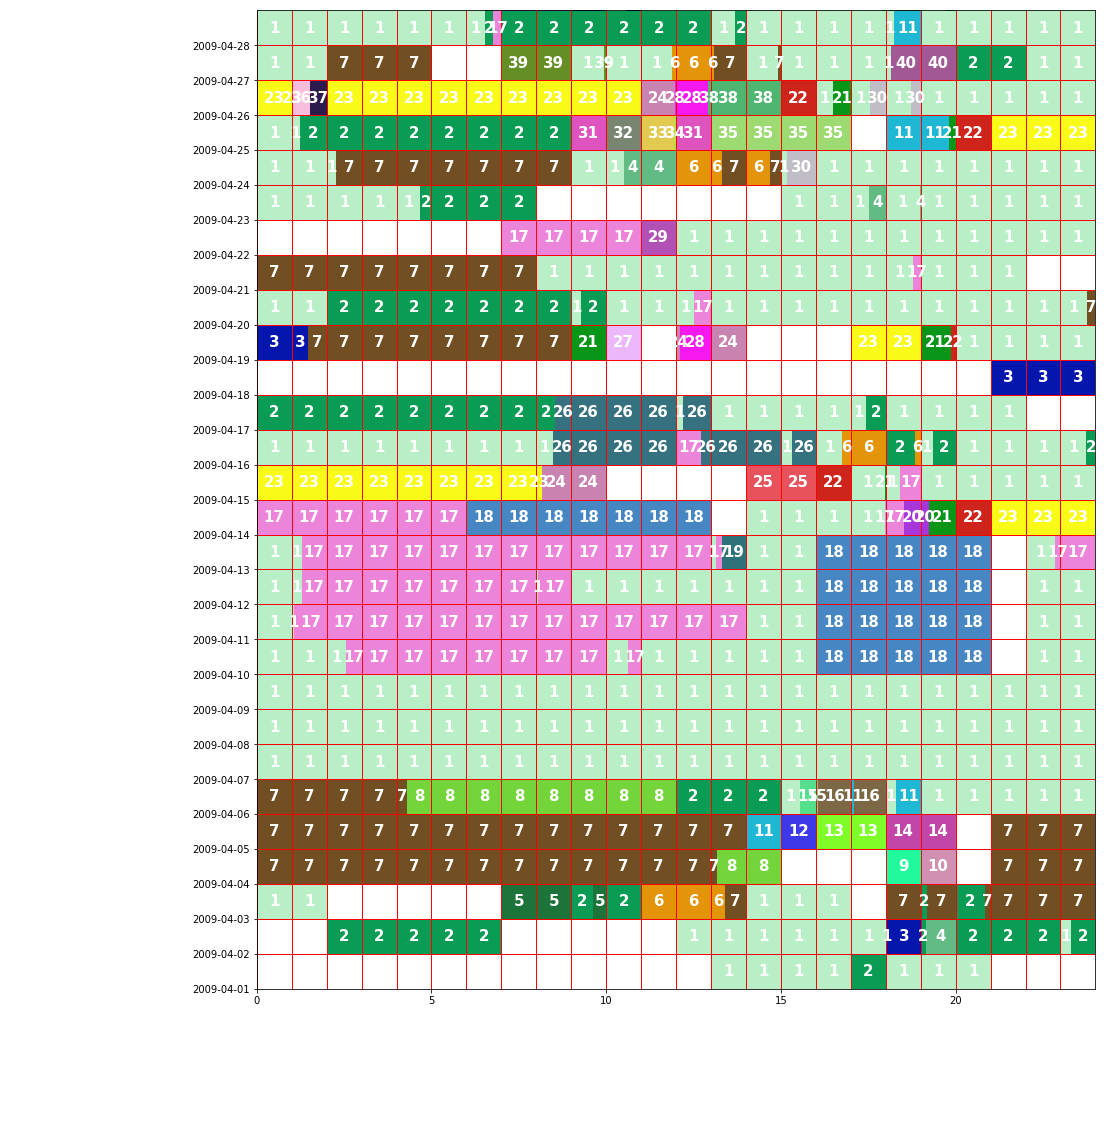

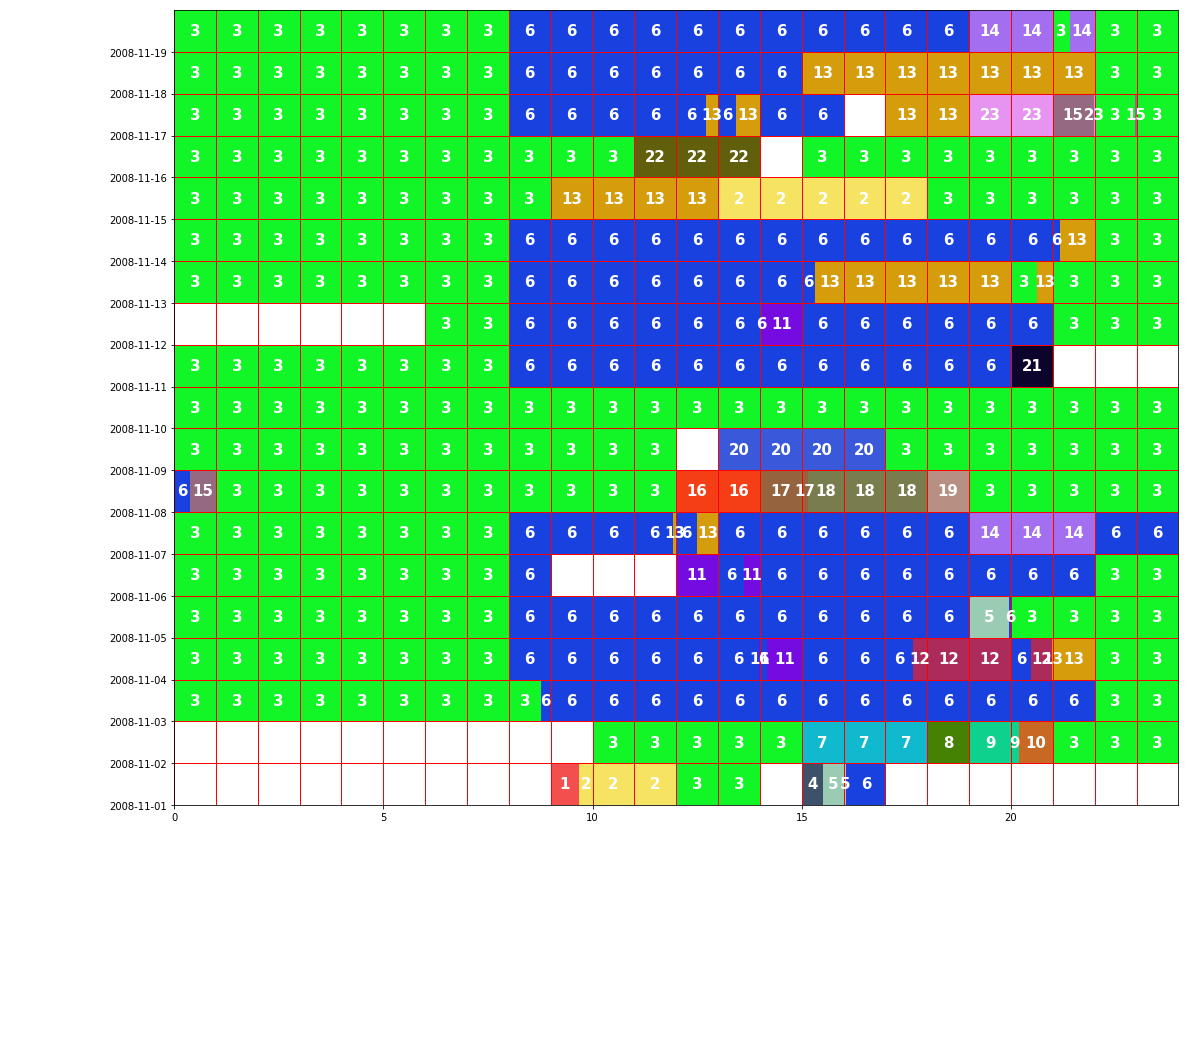

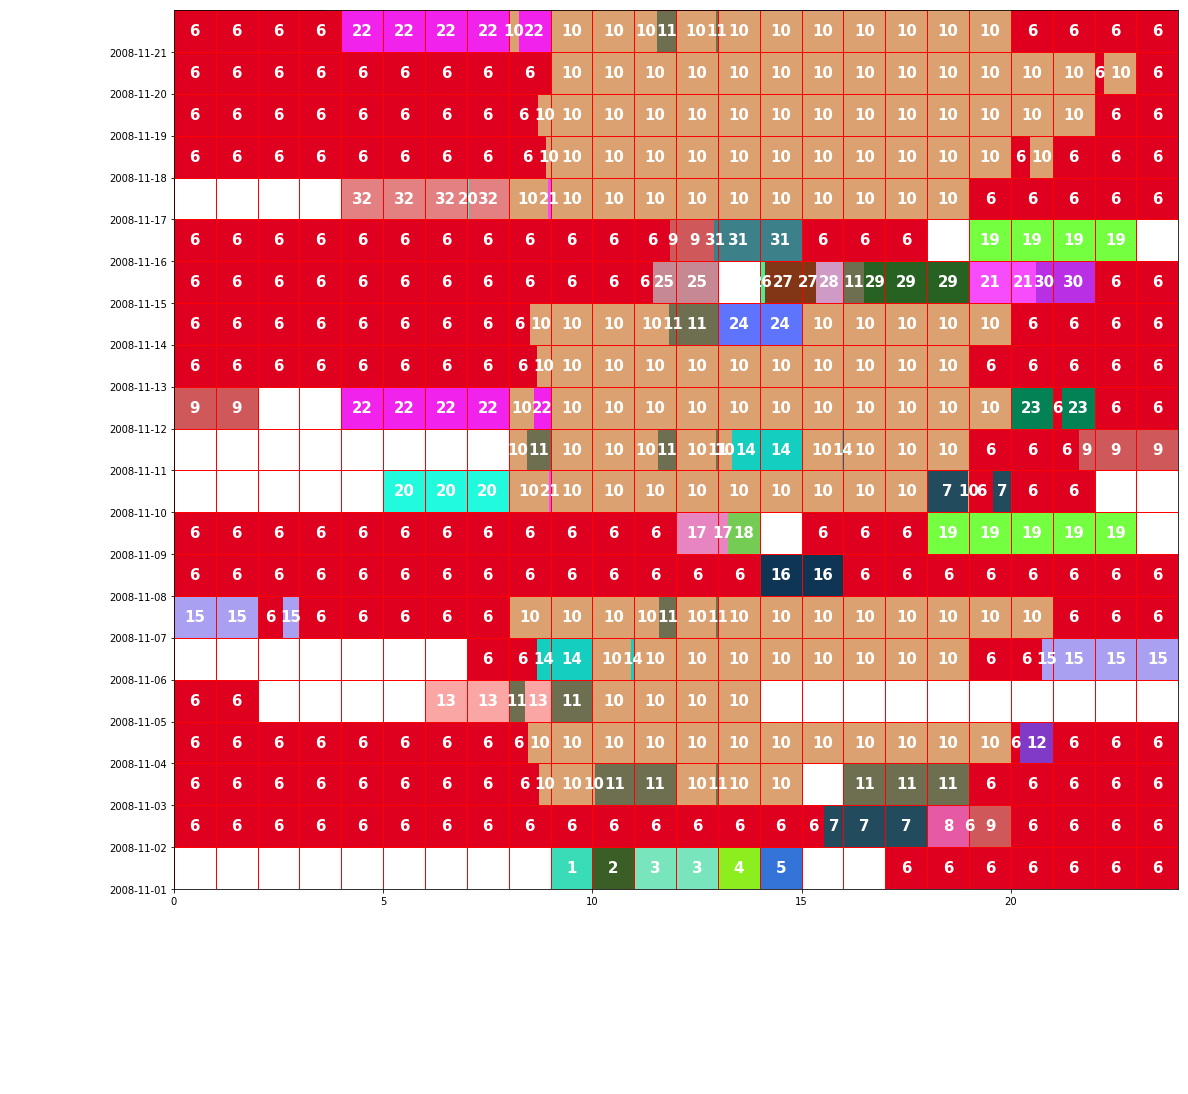

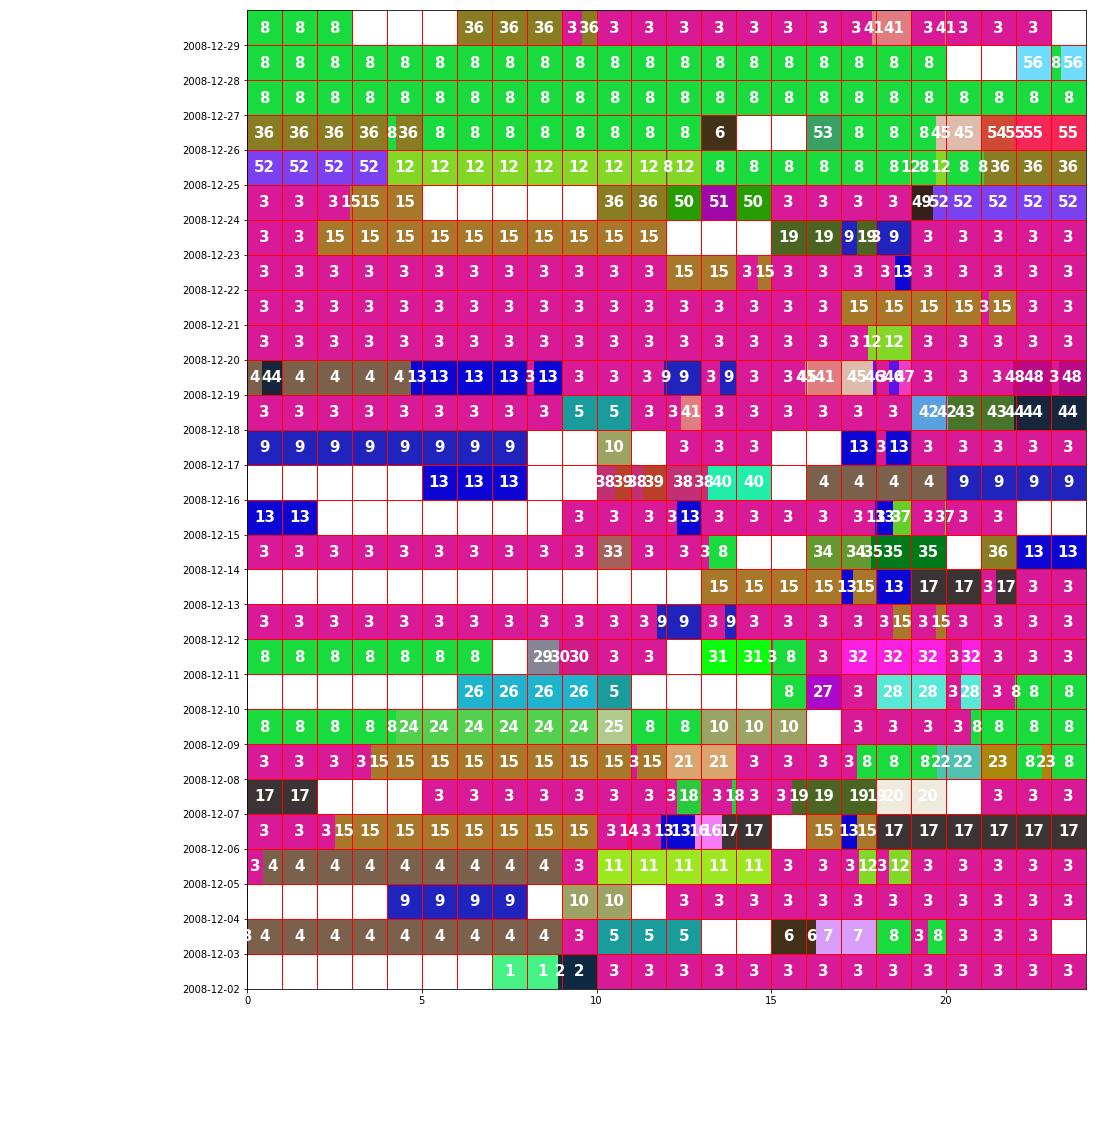

In [ ]:
#online process

#------------------------------------------------------------------------------------
def read_usr_file():
    global usr_trejec_df
    
    #Load file names for user
    filenames = glob.glob(file_source_raw)

    #Read the files
    list_of_dfs = [pd.read_csv(filename, skiprows=6, header = None) for filename in filenames]

    #put the data from list into one dataframe
    usr_trejec_df = pd.concat(list_of_dfs, ignore_index=True)
    usr_trejec_df.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
    usr_trejec_df["Timestamp"] = usr_trejec_df["Date"].map(str) + " " + usr_trejec_df["Time"]
    
    usr_trejec_df.Timestamp = pd.to_datetime(usr_trejec_df.Timestamp)
    
    #convert to china#s local time GMT + 8
    usr_trejec_df["Timestamp"] = usr_trejec_df["Timestamp"] + pd.to_timedelta(8, unit='h')
    
    usr_trejec_df.index = usr_trejec_df['Timestamp']
    usr_trejec_df = usr_trejec_df.resample('1T').mean()
    usr_trejec_df = usr_trejec_df.dropna()
    
     #add columns to user trajectory dataframe
    #1. add timestamp as column
    usr_trejec_df['Timestamp'] = pd.to_datetime(usr_trejec_df.index)
    #restore date and time column
    usr_trejec_df['Date'] = usr_trejec_df.Timestamp.dt.date
    usr_trejec_df['Time'] = usr_trejec_df.Timestamp.dt.time
    usr_trejec_df['Hour'] = usr_trejec_df.Timestamp.dt.hour
    
    #sort values based on timestamp
    usr_trejec_df = usr_trejec_df.sort_values(['Timestamp'])
    #reset index
    usr_trejec_df = usr_trejec_df.reset_index(drop=True)
    
    
    usr_trejec_df['Weekday'] = usr_trejec_df['Timestamp'].dt.weekday.map(str) + usr_trejec_df['Timestamp'].dt.weekday_name

    usr_trejec_df['StayPoint'] = -1 # 1 if it is a staypoint, else 0
    usr_trejec_df['StayptId'] = -1
    usr_trejec_df['StayMeanLat'] = -1.0
    usr_trejec_df['StayMeanLon'] = -1.0
    usr_trejec_df['State'] = -1     # 1 if it is a state, else 0
    usr_trejec_df['StateId'] = -1
    usr_trejec_df['StateMeanLat'] = -1.0
    usr_trejec_df['StateMeanLon'] = -1.0
    
    #remove columns not used/required
    usr_trejec_df = usr_trejec_df.drop(['0', 'Altitude', 'NumDays'], axis = 1)

#-------------------------------
def prepare_dfs():
    global cluster_hourly_df 

    #create cluster_hourly_df columns
    for i in range(0, 24):
        cluster_hourly_df['Date'] = 0
        cluster_hourly_df['StateId'] = 0
        cluster_hourly_df['AvgLat'] = 0
        cluster_hourly_df['AvgLon'] = 0
        cluster_hourly_df[i] = 0
        
#------------------------------------------------------------------------------------
#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters


#------------------------------------------------------------------------------------
def cluster(newlat, newlon, row, count, orig_lat, orig_lon):
    global curr_hr_df
    
    currcluster = curr_hr_df['StayptId'][row-1]
    curr_hr_df['StayptId'][row] = -1
    curr_hr_df['StayMeanLat'][row] = -1.0
    curr_hr_df['StayMeanLon'][row] = -1.0
    curr_hr_df['StayPoint'][row] = -1
    clulat = curr_hr_df['StayMeanLat'][row-1]
    clulon = curr_hr_df['StayMeanLon'][row-1]
    
    #if the new point and the old point time difference is greater than tracking threshold
    # then add both the points as staypoints and leave
    prevPointTime = curr_hr_df['Timestamp'][row-1]
    currPointTime = curr_hr_df['Timestamp'][row]
    timm_diff = (currPointTime - prevPointTime).seconds /60
    dist_diff = meters(clulat, clulon, newlat, newlon)   
    
    if (timm_diff >= track_t_thrhld and dist_diff > staypts_d_thrhld ):
        curr_hr_df.loc[row-1, 'StayPoint'] = 1
        curr_hr_df.loc[row-1, 'StayMeanLat'] = curr_hr_df.loc[row-1, 'Latitude']
        curr_hr_df.loc[row-1, 'StayMeanLon'] = curr_hr_df.loc[row-1, 'Longitude']
        curr_hr_df.loc[row, 'StayPoint'] = 1
        curr_hr_df.loc[row, 'StayMeanLat'] = curr_hr_df.loc[row, 'Latitude']
        curr_hr_df.loc[row, 'StayMeanLon'] = curr_hr_df.loc[row, 'Longitude']
        curr_hr_df.loc[row, 'StayptId'] = currcluster + 1
    else:    
        #if the new point and old point's distance is less than threshold, then add it to current cluster
        if meters(clulat, clulon, newlat, newlon)<= staypts_d_thrhld:
            curr_hr_df['StayptId'][row] = currcluster
            #calculate new mean lat and lon for the cluster
            array_lat = curr_hr_df['Latitude'].loc[curr_hr_df['StayptId'] == currcluster].values
            array_lon = curr_hr_df['Longitude'].loc[curr_hr_df['StayptId'] == currcluster].values

            #cal new means
            new_lat_mean = np.mean(array_lat)
            new_lon_mean = np.mean(array_lon)

            curr_hr_df.loc[ (curr_hr_df['StayptId']==currcluster), 'StayMeanLat'] = new_lat_mean
            curr_hr_df.loc[ (curr_hr_df['StayptId']==currcluster), 'StayMeanLon'] = new_lon_mean

    #         curr_hr_df['StayMeanLat'] = curr_hr_df.groupby('StayptId')['Latitude'].transform(np.mean)
    #         curr_hr_df['StayMeanLon'] = curr_hr_df.groupby('StayptId')['Longitude'].transform(np.mean)
            count = count + 1

        #if the new point and old point's distance is greater than threshold, it means the point moved away
        #if the previous cluster has more than two points, check the duration of the previous cluster
        #   if the duration of the previos cluster is greater than threshold, assign it as a staypoint

        #if the row read is the last row for this hour
        if (row == len(curr_hr_df)-1):
            if count >= 2:
                MinClusTime = curr_hr_df['Timestamp'][row-count+1]
                MaxClusTime = curr_hr_df['Timestamp'][row]
                k = MaxClusTime - MinClusTime
                l = int((k / np.timedelta64(1, 'm')))

                if (l >= staypts_t_thrhld):
                    curr_hr_df.loc[ (curr_hr_df['StayptId']==currcluster), 'StayPoint'] = 1      
                #incase the cluster is not a staypoint and the first point is already a staypoint
                #then retain the latitued and longitudes
                else:
                    if (row-count) == 0 and curr_hr_df['StayPoint'][row-count] == 1:
                        curr_hr_df['StayMeanLat'][row-count] = orig_lat
                        curr_hr_df['StayMeanLon'][row-count] = orig_lon

        #if the new point is moving away from the cluster
        if meters(clulat, clulon, newlat, newlon)> staypts_d_thrhld:
            if count >= 2:
                MinClusTime = curr_hr_df['Timestamp'][row-count]
                MaxClusTime = curr_hr_df['Timestamp'][row-1]
                k = MaxClusTime - MinClusTime
                l = int((k / np.timedelta64(1, 'm')))

                if (l >= staypts_t_thrhld):
                    curr_hr_df.loc[ (curr_hr_df['StayptId']==currcluster), 'StayPoint'] = 1
                #incase the cluster is not a staypoint and the first point is already a staypoint
                #then retain the latitued and longitudes
                else:
                    if (row-count) == 0 and curr_hr_df['StayPoint'][row-count] == 1:
                        curr_hr_df['StayMeanLat'][row-count] = orig_lat
                        curr_hr_df['StayMeanLon'][row-count] = orig_lon
            
            count = 1
            curr_hr_df['StayMeanLat'][row] = curr_hr_df['Latitude'][row]
            curr_hr_df['StayMeanLon'][row] = curr_hr_df['Longitude'][row]
            curr_hr_df['StayptId'][row] = currcluster + 1

    return count

#------------------------------------------------------------------------------------
def read_trained_model():
    global trained_model_df
    
    if os.path.isfile(dest_file_final_markov_chain):
        trained_model_df = pd.read_csv(dest_file_final_markov_chain, header = 0)
    
#------------------------------------------------------------------------------------
def create_last_hr_staypts():
    global curr_hr_df          #holds current hour points
    global staypts_df          #holds all staypoints
    global curr_hr_staypts_df  #holds current hour staypoints only
    global prev_hour_last_point #stores last hour last point
    
    #clear current hour staypoints dataframe
    curr_hr_staypts_df = curr_hr_staypts_df.iloc[0:0]
    
    #reset index of current hour points
    curr_hr_df = curr_hr_df.reset_index(drop=True)
    
    #feching the last stayptid 
    if not staypts_df.empty:
        stayid = staypts_df['StayptId'].max() + 1 #assign next possible staypt id
    else:
        stayid = 1 #if this is the start, start from 1 as staypointID
    
    adding_first_as_staypt = 'N'
    adding_last_as_staypt = 'N'
    orig_lat = 0
    orig_lon = 0
    if not prev_hour_last_point.empty:
        #check the time difference of last hour last point and this hour first point is greater than track t threshold
        #if yes than add both as staypoints
        if (int(time.mktime(curr_hr_df.loc[0, 'Timestamp'].timetuple()) - 
                   time.mktime(prev_hour_last_point.loc[0, 'Timestamp'].timetuple()))/60 > track_t_thrhld):
            if prev_hour_last_point.loc[0, 'StayPoint'] != 1:
                adding_last_as_staypt = 'Y'
                prev_hour_last_point.loc[0, 'StayptId'] = stayid
                stayid = stayid + 1
                prev_hour_last_point.loc[0, 'StayPoint'] = 1
                prev_hour_last_point.loc[0, 'StayMeanLat'] = prev_hour_last_point.loc[0, 'Latitude']
                prev_hour_last_point.loc[0, 'StayMeanLon'] = prev_hour_last_point.loc[0, 'Longitude']
                staypts_df = staypts_df.append(prev_hour_last_point)

            curr_hr_df.loc[0, 'StayptId'] = stayid
            stayid = stayid + 1
            curr_hr_df.loc[0, 'StayPoint'] = 1
            orig_lat = curr_hr_df.loc[0, 'Latitude']
            orig_lon = curr_hr_df.loc[0, 'Longitude']
            adding_first_as_staypt = 'Y'
        
            
    #Read the file in an online manner as the points come and assign the points to clusters
    row =1
    count = 1
    
    if adding_first_as_staypt == 'N': 
        curr_hr_df['StayptId'][row-1] = stayid
        curr_hr_df['StayPoint'][row-1] = -1
        
    curr_hr_df['StayMeanLat'][row-1] = curr_hr_df['Latitude'][0]
    curr_hr_df['StayMeanLon'][row-1] = curr_hr_df['Longitude'][0]
    
    
    while row < len(curr_hr_df):
        count = cluster(curr_hr_df['Latitude'][row], curr_hr_df['Longitude'][row], row, count, orig_lat, orig_lon)
        row= row + 1
    
    #copy the staypoints to the current hour staypoints dataframe
    curr_hr_staypts_df = curr_hr_df.loc[curr_hr_df['StayPoint'] == 1]
    #copy the stay points into another dataframe
    staypts_df = staypts_df.append(curr_hr_df.loc[curr_hr_df['StayPoint'] == 1])
    #reset staypoints index
    curr_hr_staypts_df.index = curr_hr_staypts_df['Timestamp']
    staypts_df.index = staypts_df['Timestamp']

    #store the last hour last point
    prev_hour_last_point = prev_hour_last_point.iloc[0:0]
    prev_hour_last_point = curr_hr_df.iloc[[len(curr_hr_df)-1]]
    prev_hour_last_point = prev_hour_last_point.reset_index(drop=True)
    
    #clear current hour dataframe content
    curr_hr_df = curr_hr_df.iloc[0:0]

#-----------------------------------------------------------------------------------
def add_start_end_times():
    global staypts_df
    
    if staypts_df.empty or len(staypts_df) == 1:
        return
    
    staypts_df = staypts_df.reset_index(drop=True)
    
     #state = -2 indicates it is already processed
    idx = staypts_df.index[staypts_df['State'] == -1]
    if idx.empty:
         return

    if min(idx) == 0:
        start = min(idx)
    else:
        start = min(idx) - 1
    
    prev_id = staypts_df.loc[start, 'StayptId']
    tobeadded_staypts = pd.DataFrame(columns=['Latitude', 'Longitude', 'Timestamp', 'Date', 'Time',
                                              'Hour', 'Weekday', 'StayPoint', 'StayptId', 'StayMeanLat',
                                              'StayMeanLon', 'State', 'StateId', 'StateMeanLat', 'StateMeanLon'])
    j = 0
    #import pdb; pdb.set_trace()
    for i in range(start, len(staypts_df)):
        #update state as -2 indicating processed
        staypts_df.loc[i, 'State'] = -2 
        #import pdb; pdb.set_trace()

        if staypts_df.loc[i, 'StayptId'] != prev_id:
            prev_id = staypts_df.loc[i, 'StayptId']
            strt_indx = i
            end_indx = i-1

            #calclulate time to be added
            end1_trj_time = staypts_df.loc[end_indx, 'Timestamp']
            end1_trj_lat = staypts_df.loc[end_indx, 'StayMeanLat']
            end1_trj_lon = staypts_df.loc[end_indx, 'StayMeanLon']
            str2_trj_time = staypts_df.loc[strt_indx, 'Timestamp']
            str2_trj_lat = staypts_df.loc[strt_indx, 'StayMeanLat']
            str2_trj_lon = staypts_df.loc[strt_indx, 'StayMeanLon']

            dist_btw = meters(end1_trj_lat, end1_trj_lon, str2_trj_lat, str2_trj_lon)
            time_btw = (str2_trj_time - end1_trj_time).seconds / 60

            if time_btw != 0:
                avg_speed = dist_btw/time_btw

                #if the disctance between two points is less than 2*state_d_thrhld, that mean there is an overlap
                # in this case, we cannot consider state_d_thrhld as the staypoint region, as:
                #             before user leave state_d_thrhld of this staypoint the user already enters the next staypoint
                if avg_speed != 0:
                    
                    #if dist_btw >= 2*state_d_thrhld or dist_btw <= state_d_thrhld:
                    if dist_btw >= 2*state_d_thrhld:
                        delta_t = min(state_d_thrhld, dist_btw)/avg_speed
                    else:
                        delta_t = dist_btw/(2* avg_speed)
                else:
                    delta_t = time_btw/2
                
                if delta_t <= 1440:
                    end1_trj_time = end1_trj_time + timedelta(minutes=delta_t)
                    str2_trj_time = str2_trj_time - timedelta(minutes=delta_t)

                    #add end of prev point line
                    tobeadded_staypts.loc[j, 'Latitude'] = staypts_df.loc[end_indx, 'Latitude']
                    tobeadded_staypts.loc[j, 'Longitude'] = staypts_df.loc[end_indx, 'Longitude']
                    tobeadded_staypts.loc[j, 'Timestamp'] = end1_trj_time
                    tobeadded_staypts.loc[j, 'Date'] = end1_trj_time.date()
                    tobeadded_staypts.loc[j, 'Time'] = end1_trj_time.time()
                    tobeadded_staypts.loc[j, 'Hour'] = end1_trj_time.hour
                    tobeadded_staypts.loc[j, 'Weekday'] = str(end1_trj_time.weekday())+ end1_trj_time.weekday_name
                    tobeadded_staypts.loc[j, 'StayPoint'] = 1
                    tobeadded_staypts.loc[j, 'StayptId'] = staypts_df.loc[end_indx, 'StayptId']
                    tobeadded_staypts.loc[j, 'StayMeanLat'] = staypts_df.loc[end_indx, 'StayMeanLat']
                    tobeadded_staypts.loc[j, 'StayMeanLon'] = staypts_df.loc[end_indx, 'StayMeanLon']
                    tobeadded_staypts.loc[j, 'State'] = -2   #to indicate its po´rocessed
                    tobeadded_staypts.loc[j, 'StateId'] = -1
                    tobeadded_staypts.loc[j, 'StateMeanLat'] = -1.0
                    tobeadded_staypts.loc[j, 'StateMeanLon'] = -1.0
                    j = j + 1

                    #add start of current point line
                    tobeadded_staypts.loc[j, 'Latitude'] = staypts_df.loc[strt_indx, 'Latitude']
                    tobeadded_staypts.loc[j, 'Longitude'] = staypts_df.loc[strt_indx, 'Longitude']
                    tobeadded_staypts.loc[j, 'Timestamp'] = str2_trj_time
                    tobeadded_staypts.loc[j, 'Date'] = str2_trj_time.date()
                    tobeadded_staypts.loc[j, 'Time'] = str2_trj_time.time()
                    tobeadded_staypts.loc[j, 'Hour'] = str2_trj_time.hour
                    tobeadded_staypts.loc[j, 'Weekday'] = str(str2_trj_time.weekday()) + str2_trj_time.weekday_name
                    tobeadded_staypts.loc[j, 'StayPoint'] = 1
                    tobeadded_staypts.loc[j, 'StayptId'] = staypts_df.loc[strt_indx, 'StayptId']
                    tobeadded_staypts.loc[j, 'StayMeanLat'] = staypts_df.loc[strt_indx, 'StayMeanLat']
                    tobeadded_staypts.loc[j, 'StayMeanLon'] = staypts_df.loc[strt_indx, 'StayMeanLon']
                    tobeadded_staypts.loc[j, 'State'] = -2 #to indicate its po´rocessed
                    tobeadded_staypts.loc[j, 'StateId'] = -1
                    tobeadded_staypts.loc[j, 'StateMeanLat'] = -1.0
                    tobeadded_staypts.loc[j, 'StateMeanLon'] = -1.0
                    j = j + 1

    staypts_df = staypts_df.append(tobeadded_staypts, ignore_index=True)
    staypts_df = staypts_df.sort_values(['StayptId', 'Timestamp'])
    staypts_df = staypts_df.reset_index(drop=True)            
    
    staypts_df.index = staypts_df['Timestamp']

#-------------form states-----------------------------------------------------------------------
def form_states():
    global staypts_df
    global curr_hr_staypts_df
    
    #update states in final staypoints
    #copy staypoint data as state data
    staypts_df['StateId'] = staypts_df['StayptId']
    staypts_df['StateMeanLat'] = staypts_df['StayMeanLat']
    staypts_df['StateMeanLon'] = staypts_df['StayMeanLon']
    
    #this fucntion groups the staypoints together to from different days 
    #Copy the stay points dataframe into another dataframe and remove duplicates
    staypts_df1 = staypts_df[['StateId', 'StateMeanLat', 'StateMeanLon']].copy()
    staypts_df1 = staypts_df1.drop_duplicates(subset=['StateId', 'StateMeanLat', 'StateMeanLon'])

    staypts_df1 = staypts_df1.sort_values(['StateId', 'StateMeanLat', 'StateMeanLon'])
    staypts_df1 = staypts_df1.reset_index(drop=True)
    
    row = 1
    #import pdb; pdb.set_trace()
    for i in range(0, len(staypts_df1)-1):
        for j in range(i+1, len(staypts_df1)):
        
            chk_cluster = staypts_df1['StateId'][i]
            chk_clulat = staypts_df1['StateMeanLat'][i]
            chk_clulon = staypts_df1['StateMeanLon'][i]
            curr_cluster = staypts_df1['StateId'][j]
            curr_clulat = staypts_df1['StateMeanLat'][j]
            curr_clulon = staypts_df1['StateMeanLon'][j]
        
            if meters(chk_clulat, chk_clulon, curr_clulat, curr_clulon)<= state_d_thrhld:
                #before adding this point to the ith state, 
                #   calculate new mean with jth point,
                #   if the new mean is still keeping all the states with id(i) than add jth to the state
                #   else not
                
                add_state = "Yes"
                #form the existing lat and lon array
                array_lat = staypts_df['Latitude'].loc[staypts_df['StateId'] == chk_cluster].values
                array_lon = staypts_df['Longitude'].loc[staypts_df['StateId'] == chk_cluster].values
                #add the new lat and lon values to the array
                new_lats = staypts_df['Latitude'].loc[staypts_df['StateId'] == curr_cluster].values
                new_lons = staypts_df['Longitude'].loc[staypts_df['StateId'] == curr_cluster].values
                
                array_lat= np.append(array_lat, new_lats)
                array_lon= np.append(array_lon, new_lons)
                #cal new means
                new_lat_mean = np.mean(array_lat)
                new_lon_mean = np.mean(array_lon)
                
                for k in range(0, len(array_lat)):
                    if meters(array_lat[k], array_lon[k], new_lat_mean, new_lon_mean) > state_d_thrhld:
                        add_state = "No"
                        
                if add_state == "Yes":    
                    staypts_df.loc[ (staypts_df['StateId']==curr_cluster), 'StateId'] = chk_cluster
                    staypts_df.loc[ (staypts_df['StateId']==chk_cluster), 'StateMeanLat'] = new_lat_mean
                    staypts_df.loc[ (staypts_df['StateId']==chk_cluster), 'StateMeanLon'] = new_lon_mean
                
    #update states for last hour staypoints
    #copy staypoint data as state data
    #copy staypoint data as state data
    curr_hr_staypts_df['StateId'] = curr_hr_staypts_df['StayptId']
    curr_hr_staypts_df['StateMeanLat'] = curr_hr_staypts_df['StayMeanLat']
    curr_hr_staypts_df['StateMeanLon'] = curr_hr_staypts_df['StayMeanLon']
    
    #this fucntion groups the staypoints together to from different days 
    #Copy the stay points dataframe into another dataframe and remove duplicates
    curr_hr_staypts_df1 = curr_hr_staypts_df[['StateId', 'StateMeanLat', 'StateMeanLon']].copy()
    curr_hr_staypts_df1 = curr_hr_staypts_df1.drop_duplicates(subset=['StateId', 'StateMeanLat', 'StateMeanLon'])

    curr_hr_staypts_df1 = curr_hr_staypts_df1.sort_values(['StateId', 'StateMeanLat', 'StateMeanLon'])
    curr_hr_staypts_df1 = curr_hr_staypts_df1.reset_index(drop=True)
    
    row = 1

    for i in range(0, len(curr_hr_staypts_df1)):
        for j in range(i+1, len(curr_hr_staypts_df1)):
        
            chk_cluster = curr_hr_staypts_df1['StateId'][i]
            chk_clulat = curr_hr_staypts_df1['StateMeanLat'][i]
            chk_clulon = curr_hr_staypts_df1['StateMeanLon'][i]
            curr_cluster = curr_hr_staypts_df1['StateId'][j]
            curr_clulat = curr_hr_staypts_df1['StateMeanLat'][j]
            curr_clulon = curr_hr_staypts_df1['StateMeanLon'][j]
        
            if meters(chk_clulat, chk_clulon, curr_clulat, curr_clulon)<= state_d_thrhld:
                #before adding this point to the ith state, 
                #   calculate new mean with jth point,
                #   if the new mean is still keeping all the states with id(i) than add jth to the state
                #   else not
                
                add_state = "Yes"
                #form the existing lat and lon array
                array_lat = curr_hr_staypts_df['Latitude'].loc[curr_hr_staypts_df['StateId'] == chk_cluster].values
                array_lon = curr_hr_staypts_df['Longitude'].loc[curr_hr_staypts_df['StateId'] == chk_cluster].values
                #add the new lat and lon values to the array
                new_lats = curr_hr_staypts_df['Latitude'].loc[curr_hr_staypts_df['StateId'] == curr_cluster].values
                new_lons = curr_hr_staypts_df['Longitude'].loc[curr_hr_staypts_df['StateId'] == curr_cluster].values
                
                array_lat= np.append(array_lat, new_lats)
                array_lon= np.append(array_lon, new_lons)
                #cal new means
                new_lat_mean = np.mean(array_lat)
                new_lon_mean = np.mean(array_lon)
                
                for k in range(0, len(array_lat)):
                    if meters(array_lat[k], array_lon[k], new_lat_mean, new_lon_mean) > state_d_thrhld:
                        add_state = "No"
                        
                if add_state == "Yes":    
                    curr_hr_staypts_df.loc[ (curr_hr_staypts_df['StateId']==curr_cluster), 'StateId'] = chk_cluster
                    curr_hr_staypts_df.loc[ (curr_hr_staypts_df['StateId']==curr_cluster), 'StateMeanLat'] = new_lat_mean
                    curr_hr_staypts_df.loc[ (curr_hr_staypts_df['StateId']==curr_cluster), 'StateMeanLon'] = new_lon_mean

#------------------------------------------------------------------------------------

def cal_hourly_state_weight():
    global cluster_hourly_df  
    global staypts_df

    curr_hr_cluster_hourly_df = pd.DataFrame()       
    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.reset_index(drop=True)
    staypts_df = staypts_df.reset_index(drop=True)

    last_hour = staypts_df['Timestamp'][0].hour
    last_clusid = staypts_df['StateId'][0]
    curr_count = 0
    row = 0
    currstate_timestamps = []
    currstate_timestamps =  np.append(currstate_timestamps, staypts_df.loc[0, 'Timestamp'])

    for i in range(0, 24):
        curr_hr_cluster_hourly_df['Date'] = 0
        curr_hr_cluster_hourly_df['StateId'] = 0
        curr_hr_cluster_hourly_df['AvgLat'] = 0
        curr_hr_cluster_hourly_df['AvgLon'] = 0
        curr_hr_cluster_hourly_df[i] = 0

    for i in range(1, len(staypts_df)):

        if (staypts_df['StateId'][i] != last_clusid):
            start = min(currstate_timestamps)
            end = max(currstate_timestamps)

            #if the state is with one hour
            if start.hour == end.hour:
                k = end - start
                mins = int((k / np.timedelta64(1, 'm')))

                date_read = start.date()
                cluster_id = staypts_df['StateId'][i-1]
                cluster_mean_lat = staypts_df['StateMeanLat'][i-1]
                cluster_mean_lon = staypts_df['StateMeanLon'][i-1]
                col_name = start.hour

                curr_hr_cluster_hourly_df.loc[row, 'AvgLat'] = cluster_mean_lat
                curr_hr_cluster_hourly_df.loc[row, 'AvgLon'] = cluster_mean_lon
                curr_hr_cluster_hourly_df.loc[row, 'Date'] = date_read
                curr_hr_cluster_hourly_df.loc[row, 'StateId'] = cluster_id
                curr_hr_cluster_hourly_df.loc[row, col_name] = round((mins)/60,4)
                row = row + 1

            #if the state is beyond one hour boundary
            else:
                end = end + pd.Timedelta(hours=1) - pd.Timedelta(minutes=end.minute)
                j = start
                while j < end:
                    if j == start:
                        k = ((j + pd.Timedelta(hours=1) - pd.Timedelta(minutes=j.minute)) - j)
                        mins = int((k / np.timedelta64(1, 'm')))
                    elif j.hour == end.hour - 1:
                        end_time = max(currstate_timestamps)
                        k = (end_time - (end_time - pd.Timedelta(minutes=end_time.minute)))
                        mins = int((k / np.timedelta64(1, 'm')))
                    else:
                        mins = 60

                    date_read = j.date()
                    cluster_id = staypts_df['StateId'][i-1]
                    cluster_mean_lat = staypts_df['StateMeanLat'][i-1]
                    cluster_mean_lon = staypts_df['StateMeanLon'][i-1]
                    col_name = j.hour

                    curr_hr_cluster_hourly_df.loc[row, 'AvgLat'] = cluster_mean_lat
                    curr_hr_cluster_hourly_df.loc[row, 'AvgLon'] = cluster_mean_lon
                    curr_hr_cluster_hourly_df.loc[row, 'Date'] = date_read
                    curr_hr_cluster_hourly_df.loc[row, 'StateId'] = cluster_id
                    curr_hr_cluster_hourly_df.loc[row, col_name] = round((mins)/60,4)
                    row = row + 1

                    j = j + pd.Timedelta(hours=1)

            currstate_timestamps = []
            currstate_timestamps =  np.append(currstate_timestamps, staypts_df.loc[i, 'Timestamp'])
            last_clusid = staypts_df['StateId'][i]
        else:
            currstate_timestamps =  np.append(currstate_timestamps, staypts_df.loc[i, 'Timestamp'])


    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.fillna(0)
    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.groupby(['Date', 'StateId', 'AvgLat', 'AvgLon']).sum()
    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.reset_index(level=[0,1,2,3])
   
    cluster_hourly_df = curr_hr_cluster_hourly_df
    cluster_hourly_df = cluster_hourly_df.reset_index(drop=True)
    
    #normalize the hourly weights
    for i in range(0, 24):
        col = "Sum" + str(i)
        cluster_hourly_df[col] = cluster_hourly_df.groupby('Date')[i].transform(np.sum)

    for i in range(0, 24):
        col = "Sum" + str(i)
        cluster_hourly_df[i] = cluster_hourly_df[i]/cluster_hourly_df[col]
        cluster_hourly_df = cluster_hourly_df.drop([col], axis=1)
    cluster_hourly_df = cluster_hourly_df.fillna(0)
    
#------------------------------------------------------------------------------------------------
def del_staypts_less_dur(prev_date):
    global staypts_df
    
    staypts_df = staypts_df.reset_index(drop=True)
    idx = staypts_df.index[staypts_df['Date'] == prev_date]
    if idx.empty:
         return
    start = min(idx) + 1

    prev_stateid = staypts_df.loc[start-1, 'StateId'] 
    state_cur_count = 1
    for i in range(start, len(staypts_df)):
        if (prev_stateid != staypts_df.loc[i, 'StateId'] ):

            duration = staypts_df.loc[i-1, 'Timestamp'] - staypts_df.loc[i-state_cur_count, 'Timestamp']
            seconds = duration.seconds
            minutes = seconds / 60

            if minutes < staypts_t_thrhld:
                for j in range(i-state_cur_count, i):
                    staypts_df.loc[j, 'State'] = -3

            state_cur_count = 1
            prev_stateid = staypts_df.loc[i, 'StateId']
        else:
            state_cur_count = state_cur_count + 1

    staypts_df = staypts_df[staypts_df.State != -3]
    staypts_df = staypts_df.reset_index(drop=True)
    staypts_df.index = staypts_df['Timestamp']
    
# ------------------------------------------------------------------------------------------------
def visualize_hourly_state_weight():
    global cluster_hourly_df
    
    dicts = {}
    pos_dicts = {}
    clu_list = []
    clu_list = cluster_hourly_df['StateId'].unique()
    r = lambda: random.randint(0, 255)

    for i in range(0, len(clu_list)):
        # icts[clu_list[i]] = (colors[i])
        dicts[clu_list[i]] = ('#%02X%02X%02X' % (r(), r(), r()))

     # create a new graph where we will later add rectangles for each hour:cluster
    fig2 = plt.figure(figsize=(18, 18))
    ax1 = fig2.add_subplot(111, aspect='equal')

    # get all the dates for y axis
    date_list = cluster_hourly_df['Date'].unique()
    days_diff = (max(date_list) - min(date_list)).days
    date_range = [min(date_list) + dt.timedelta(days=x) for x in range(0, days_diff)]
    y = range(0, len(date_range))
    def_yticks = date_range
    plt.yticks(y, def_yticks)

    # set the x axis limit from 0-24 hours of a day, y axis with dates
    limsx = (0, 24)
    limsy = (0, len(date_range))

    date_counter = 0
    last_date = cluster_hourly_df['Date'][0]
    curr_count = 0
    j = 0

    # drawing verical lines for each hour
    for i in range(0, 24):
        ax1.axvline(x=i, linewidth=1, color='r')
    # horizontal lines
    for i in range(0, len(date_range)):
        ax1.axhline(y=i, linewidth=1, color='r')

    for i in range(0, 24):
        pos_dicts[i] = i

    for i in range(0, len(cluster_hourly_df)):

        if cluster_hourly_df.loc[i, 'Date'] != last_date:
            for k in range(0, 24):
                pos_dicts[k] = k
            add_days = (cluster_hourly_df['Date'][i] - last_date).days
            date_counter = date_counter + add_days
            last_date = cluster_hourly_df['Date'][i]

        for j in range(0, 24):

            a = float(pos_dicts.get(j))   
            b = a + cluster_hourly_df.loc[i, j]
            pos_dicts[j] = b
            width = b - a
            height = 1
            if width != 0:
                col_id = dicts.get(cluster_hourly_df['StateId'][i])
                ax1.add_patch(patches.Rectangle((a, date_counter), width, height, color=col_id,
                                            label=cluster_hourly_df['StateId'][i]))
                ax1.annotate(int(cluster_hourly_df['StateId'][i]), (a + width / 2, height / 2 + date_counter),
                         color='w', weight='bold', fontsize=15, ha='center', va='center')
    plt.xlim(limsx)
    plt.ylim(limsy)
    destpng = usr_directory + "/online.png"
    plt.savefig(destpng)
    plt.show()
#-----------------------------------------------------------------------------------
def update_staypts_csv():
    staypts_df.to_csv(dest_file_staypoints, sep='\t', encoding='utf-8')
#-----------------------------------------------------------------------------------
def update_hourly_weights_csv():
    cluster_hourly_df.to_csv(dest_file_hourly_weights,  sep='\t', encoding='utf-8')
#-----------------------------------------------------------------------------------    
def combine_states():
    global cluster_hourly_df

    # create a temp dataframe for each data, and calculate trasition matrices from hour t to t+1
    for i in range(0, len(cluster_hourly_df)):
        for j in range(i + 1, len(cluster_hourly_df)):
            if (cluster_hourly_df.loc[i, 'StateId'] != cluster_hourly_df.loc[j, 'StateId']) and (meters(cluster_hourly_df.loc[i, 'AvgLat'], cluster_hourly_df.loc[i, 'AvgLon'],
                       cluster_hourly_df.loc[j, 'AvgLat'], cluster_hourly_df.loc[j, 'AvgLon']) <= staypts_d_thrhld):
                state_id = cluster_hourly_df.loc[i, 'StateId']
                mean_lat = (cluster_hourly_df.loc[i, 'AvgLat'] + cluster_hourly_df.loc[j, 'AvgLat']) / 2
                mean_lon = (cluster_hourly_df.loc[i, 'AvgLon'] + cluster_hourly_df.loc[j, 'AvgLon']) / 2
                cluster_hourly_df.loc[(cluster_hourly_df['StateId'] == cluster_hourly_df.loc[j, 'StateId']), 'StateId'] = state_id
                cluster_hourly_df.loc[(cluster_hourly_df['StateId'] == state_id), 'AvgLat'] = mean_lat
                cluster_hourly_df.loc[(cluster_hourly_df['StateId'] == state_id), 'AvgLon'] = mean_lon

    cluster_hourly_df = cluster_hourly_df.groupby(['Date', 'StateId', 'AvgLat', 'AvgLon']).sum()
    cluster_hourly_df = cluster_hourly_df.reset_index(level=[0, 1, 2, 3])

#------------------------------------------------------------------------------------
def change_ids():
    global cluster_hourly_df
    state_dict = {}

    state_list = cluster_hourly_df['StateId'].unique()

    for i in range(0, len(state_list)):
        state_dict[state_list[i]] = i+1

    for i in range(0, len(cluster_hourly_df)):
        new_id = state_dict.get(cluster_hourly_df.loc[i, 'StateId'])
        cluster_hourly_df.loc[i, 'StateId'] = new_id


#------------------------------------------------------------------------------------
def create_save_seperate_trasition_matrices():
    date_list = cluster_hourly_df['Date'].unique()
    
    #create a temp dataframe for each data, and calculate trasition matrices from hour t to t+1
    for p in range(0, cluster_hourly_df['Date'].nunique()):

        #create a temp dataframe for pervious date
        temp_df = pd.DataFrame()
        matrices_df = pd.DataFrame()
        temp_df = cluster_hourly_df.loc[cluster_hourly_df['Date'] == date_list[p]]
        temp_df = temp_df.reset_index(drop=True)

        for i in range(0, 24):
            matrices_df['Date'] = 0
            matrices_df['StateId'] = 0
            for j in range(0, len(temp_df)):
                colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(temp_df['StateId'][j])
                matrices_df[colname] = 0

        matrices_df['Date'] = temp_df['Date']
        matrices_df['StateId'] = temp_df['StateId']

        for i in range (0, 23):
            for j in range (0, len(temp_df)):
                for k in range (0, len(temp_df)):
                    prob = temp_df[i][j] * temp_df[i+1][k]
                    colname = '(' + str(i+1) + '-' + str(i+2) + ')-' + str(temp_df['StateId'][k])
                    matrices_df[colname][j] = prob
                    
        for j in range (0, len(temp_df)):
                for k in range (0, len(temp_df)):
                    prob = temp_df[23][j] * temp_df[0][k]
                    colname = '(' + str(0) + '-' + str(1) + ')-' + str(temp_df['StateId'][k])
                    matrices_df[colname][j] = prob
                    
        file_name = dest_path_each_day_trsn_mat + str(date_list[p]) + ".csv"
        matrices_df.to_csv(file_name, sep='\t', encoding='utf-8')

#------------------------------------------------------------------------------------
def create_save_markov_chains():
    global final_transition_df
    global co_loc
    
    final_transition_df = pd.DataFrame()

    #create an empty markov chain frame for each state, and transition for each hour of the day
    date_list = cluster_hourly_df['Date'].unique()
    cluster_list = cluster_hourly_df['StateId'].unique()
    AvgLat_list = cluster_hourly_df['AvgLat'].unique()
    AvgLon_list = cluster_hourly_df['AvgLon'].unique()

    for i in range(0, 24):
        final_transition_df['Address'] = 0
        final_transition_df['AvgLat'] = 0
        final_transition_df['AvgLon'] = 0
        final_transition_df['StateId'] = 0
        for j in range(0, cluster_hourly_df['StateId'].nunique()):
            colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(cluster_list[j])
            final_transition_df[colname] = 0

    final_transition_df['StateId'] = cluster_list
    final_transition_df['AvgLat'] = AvgLat_list
    final_transition_df['AvgLon'] = AvgLon_list
    final_transition_df = final_transition_df.fillna(0)
    final_transition_df.index = final_transition_df.StateId

    #read each day file and sum the matching rows:cols combinations
    date_list = cluster_hourly_df['Date'].unique()
    path_dir = dest_path_each_day_trsn_mat

    for p in range(0, cluster_hourly_df['Date'].nunique()):
        temp_df = pd.DataFrame()
        filename = path_dir + str(date_list[p]) + '.csv'
        temp_df =  pd.read_csv(filename, header = 0, sep='\t')

        for i in range(0, len(temp_df)):
            rowname = temp_df['StateId'][i]
            for src_column in temp_df:
                for dest_column in final_transition_df:
                    if src_column == dest_column and src_column != 'StateId' :
                        #import pdb; pdb.set_trace()
                        final_transition_df[dest_column][rowname] = (final_transition_df[dest_column][rowname] +
                                                                    temp_df[src_column][i])

    #replace zero to a small value 
    final_transition_df = final_transition_df.fillna(0)                    
    final_transition_df = final_transition_df.replace(0, 0.00001)

    #calculate probability from cluster x to cluster y from time t to t+1
    final_transition_df = final_transition_df.reset_index(drop=True)
    for clus in range(0, len(final_transition_df)):
        for i in range(0, 24):
            temp_sum = 0
            for j in range(0, len(final_transition_df)):
                colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(final_transition_df['StateId'][j])
                temp_sum += (final_transition_df[colname][clus])
            for k in range(0, len(final_transition_df)):
                colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(final_transition_df['StateId'][k])
                if temp_sum != 0:
                    final_transition_df[colname][clus] = final_transition_df[colname][clus]/temp_sum

    #create dictionary for coordinate : address
    points = tuple(zip(final_transition_df.AvgLat, final_transition_df.AvgLon))
    geocoder = Nominatim(timeout=10)
    coordinate_location = {}

    for coordinate in points:
        try:
            location = geocoder.reverse(coordinate)
        except:
            location = 'unknown'
        coordinate_location[coordinate] = location

    co_loc = {k:v for k,v in coordinate_location.items()}

    for i in range(0, len(final_transition_df)):
        address = co_loc.get((final_transition_df['AvgLat'][i], final_transition_df['AvgLon'][i]))
        if address == 'unknown':
            final_transition_df['Address'][i] = 'unknown'
        else:
            final_transition_df['Address'][i] = address[0]

    #save the file
    final_transition_df.to_csv(dest_file_final_markov_chain)

    for i in range(0, 24):
        final_transition_temp_df = pd.DataFrame()
        k = cluster_hourly_df['StateId'].nunique()*i + 4
        final_transition_temp_df = final_transition_df.iloc[:,k:k + cluster_hourly_df['StateId'].nunique()]
        final_transition_temp_df.index = cluster_list
        file_name = usr_markov_chains_directory + "/" + str(i) + " hour.csv"
        final_transition_temp_df.to_csv(file_name, sep='\t', encoding='utf-8')

#------------------------------------------------------------------------------------
def predict(prev_hour):
    global trained_model_df
    global curr_hr_staypts_df
    
    tobepredicted_df = curr_hr_staypts_df[['StateId', 'StateMeanLat', 'StateMeanLon', 'Timestamp']]
    tobepredicted_df = tobepredicted_df.drop_duplicates()
    tobepredicted_df = tobepredicted_df.reset_index(drop=True)

    for j in range(0, len(tobepredicted_df)):

        new_lat = tobepredicted_df['StateMeanLat'][j]
        new_lon = tobepredicted_df['StateMeanLon'][j]
        #file_name = "PredTime- " +  str(tobepredicted_df['Timestamp'][j]) + ".csv"
        file_name = "Pred" + ".csv"
        for i in range(0, len(trained_model_df)):

            trn_lat = trained_model_df['AvgLat'][i]
            trn_lon = trained_model_df['AvgLon'][i]
            if meters(trn_lat, trn_lon, new_lat, new_lon) <= state_d_thrhld:

                predic_df = pd.DataFrame()

                cluster_id = trained_model_df['StateId'][i]
                curr_lat = trained_model_df['AvgLat'][i]
                curr_lon = trained_model_df['AvgLon'][i]
                curr_add = trained_model_df['Address'][i]
                pred_loc = {"current":(cluster_id, curr_lat, curr_lon, curr_add)}

                from_col_no = trained_model_df['StateId'].nunique() * prev_hour + 5
                to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                predic_df = trained_model_df.iloc[i:i+1,from_col_no:to_col_no]
                predic_df = predic_df.T
                predic_df['StateId'] = cluster_id
                predic_df['PredState'] = predic_df.index
                predic_df['PredState'] = predic_df['PredState'].map(lambda x: x.split('-', 2)[-1])
                predic_df.columns = ['Probability', 'StateId', 'PredState']
                predic_df = predic_df.sort_values('Probability', ascending=False).head(5)
                predic_df['Address'] = 0
                predic_df['Latitude'] = 0.0
                predic_df['Longitude'] = 0.0
                predic_df = predic_df.reset_index(drop=True)

                for j in range (0, len(predic_df)):
                    #import pdb; pdb.set_trace()
                    clus_to_find = int(float(predic_df['PredState'][j]))
                    add = trained_model_df.loc[ (trained_model_df['StateId'] == clus_to_find), 'Address'].values[0]
                    lat = trained_model_df.loc[ (trained_model_df['StateId'] == clus_to_find), 'AvgLat'].values[0]
                    lon = trained_model_df.loc[ (trained_model_df['StateId'] == clus_to_find), 'AvgLon'].values[0]

                    predic_df.loc[j, 'Address'] = add
                    predic_df.loc[j, 'Latitude'] = lat
                    predic_df.loc[j, 'Longitude'] = lon
                file = dest_predicted_dir + file_name
                print("Prediction --\n")
                print("Current hour - " + str(prev_hour))
                print("\nPrediction\n")
                print(predic_df)
                predic_df.to_csv(file, sep='\t', encoding='utf-8')
                break
            
#------------------------------------------ S T A R T -----------------------------------------------
def main():
    global usr_trejec_df
    global trained_model_df
    global curr_hr_df
    global curr_hr_staypts_df
    global staypts_df
    global cluster_hourly_df
    global final_transition_df
    
    #read test user trajectory file. In real scenerio, this will be the GPS read data
    read_usr_file()

    #prepere dataframes
    prepare_dfs()

    #Save first date and time as prev date and time for the start
    prev_date = usr_trejec_df['Date'][0]
    prev_hour = usr_trejec_df['Hour'][0]

    #I. Read the new locations in an online gps location input mode
    #  1. Everytime the hour changes, 
    #                  A. Find staypoints for the last hour and assign staypointID
    #                  B. Cluster staypoints based on distance for last hour, form states and assign stateID
    #                  C. Calculate state hourly weights for last hour
    #                  D. Predict based on trained data(if available)
    #  2. Everytime the date changes,
    #                  A. Add the days data into the training data
    #  3. If the hour and the time has not been changed, add the data to current hour data

    #I
    for i in range(0, len(usr_trejec_df)):

        #store the read hour and date as new hour and new date
        new_hour = usr_trejec_df['Hour'][i]
        new_date = usr_trejec_df['Date'][i]

        #1. 
        #if the hour has changed
        if (new_hour != prev_hour): 
            #process the last hour data if available
            if not curr_hr_df.empty:
                #A.
          
                create_last_hr_staypts() 
                add_start_end_times()
                if not curr_hr_staypts_df.empty:
                     #B.
                    form_states()
                    #read_trained_model()
                    #if not trained_model_df.empty:
                    #    predict(prev_hour)
            
            prev_hour = new_hour 
            curr_hr_df = curr_hr_df.iloc[0:0]
            curr_hr_df = curr_hr_df.append(usr_trejec_df.iloc[[i]])  
         #2. 
         #if the date has changed
            if (new_date != prev_date):
                if not staypts_df.empty:
                    #del_staypts_less_dur(prev_date)
                    #visualize_hourly_state_weight()
                    cal_hourly_state_weight()
                    update_staypts_csv()
                prev_date = new_date           

        #3. 
        #if the date and the hour has not changed, just add it to current hour dataframe.
        # this dataframe is used once the hour is changed.
        else:
            curr_hr_df = curr_hr_df.append(usr_trejec_df.iloc[[i]])   
    
    combine_states()
    change_ids()
    update_hourly_weights_csv()
    create_save_seperate_trasition_matrices()
    create_save_markov_chains()   
    if not cluster_hourly_df.empty:
        visualize_hourly_state_weight()
#---------------------------------------------------------------------------------------------------------------------
#--------------------------------------CHANGE INPUTS HERE-------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------
state_d_thrhld = 200
staypts_d_thrhld = 200
staypts_t_thrhld = 20
track_t_thrhld = 30
#destination paths
base_path = r"C:\Users\12sha\Documents\thesislocation\code_\stay points\v0.8 results"


for i in range (0, 182):
    user = usern_mnth_df.loc[i, 'user']
    month = usern_mnth_df.loc[i, 'year'] + usern_mnth_df.loc[i, 'month']
    
    #source paths
    file_source_raw = "C:/Users/12sha/Documents/Geolife Trajectories 1.3/Data/" + user + "/Trajectory/" + month + "*.plt"

    #---------------------------------------------------------------------------------------------------------------------
    #--------------------------------------CHANGE INPUTS HERE-------------------------------------------------------------
    #---------------------------------------------------------------------------------------------------------------------
    usr_directory = base_path + "/User " + user + "/" + month
    usr_hrly_wght_directory = base_path + "/User " + user  + "/" + month + "/hourlyweights"
    usr_sty_pts_directory = base_path + "/User " + user + "/" + month + "/staypoints"
    usr_markov_chains_directory = base_path + "/User " + user + "/" + month + "/markovchains"
    dest_predicted_dir = base_path + "/User " + user + "/" + month + "/predict/"

    if not os.path.exists(usr_directory):
        os.makedirs(usr_directory)
    if not os.path.exists(usr_hrly_wght_directory):
        os.makedirs(usr_hrly_wght_directory)
    if not os.path.exists(usr_sty_pts_directory):
        os.makedirs(usr_sty_pts_directory)  
    if not os.path.exists(usr_markov_chains_directory):
        os.makedirs(usr_markov_chains_directory)  
    if not os.path.exists(dest_predicted_dir):
        os.makedirs(dest_predicted_dir)  

    #destination file names
    dest_file_staypoints = usr_sty_pts_directory + "/staypoints.csv"
    dest_file_hourly_weights = usr_hrly_wght_directory + "/hourlyweights.csv"
    dest_path_each_day_trsn_mat = usr_hrly_wght_directory + "/"
    dest_file_final_markov_chain = usr_markov_chains_directory + "/final.csv"

    #remove if the file already exists

    try:
        os.remove(dest_file_staypoints)   
    except OSError:
        pass
    try:
        os.remove(dest_file_hourly_weights)
    except OSError:
        pass
    try:
        os.remove(dest_file_final_markov_chain)
    except OSError:
        pass

    #global dataframes used
    #user raw trajectory dataframe
    usr_trejec_df = pd.DataFrame()
    #user trained model
    trained_model_df = pd.DataFrame()
    #current hour points
    curr_hr_df = pd.DataFrame()
    #current hour staypoints
    curr_hr_staypts_df = pd.DataFrame()
    #last hour last point
    prev_hour_last_point = pd.DataFrame()
    #all staypoints
    staypts_df = pd.DataFrame()
    #hourly cluster
    cluster_hourly_df = pd.DataFrame()
    #final markov chains
    final_transition_df = pd.DataFrame()

    clus_dict = {}
    co_loc = {}
    pred_loc = {}
    lat_array = []
    lon_array = []
    global_count = 0

    #---------------------------------------------------------------------------------------------------
    main()
